# Imports

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
# set display options for browsing large dataframes
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

# library of helper functions and class-constructors
import PaulBettany as jarvis


In [47]:
# Read in data
train = pd.read_csv('../data/train.csv', index_col = 'Id')
test = pd.read_csv('../data/test.csv', index_col = 'Id')

# Whatever cleaning/feature engineering we do to the training set
# will have to be done on the test set as well
# (otherwise, we won't be able to input the test data into our training set)
aggregate = pd.concat([train,test])

train.shape, test.shape, aggregate.shape

((2051, 80), (878, 79), (2929, 80))

# Prelude: A Custom Class: the ```Project``` Object

For this project (and probably for all future Machine Learning projects), we created a custom class ```Project``` to help organize all the data as we cycle through different edits, models, and feature manipulations.

**Design Philosophy:** The goal is to build a regression model to predict target values on an unlabelled data set. Our workflow consists of 3 main steps: 

    Select Features/Hyperparameters -> Generate Model -> Test Model.

And what we desire is to compartmentalize and save the results of this workflow into a single environment, which we think of as the ```Project``` object.

<br>
    
1) **Feature Selection**. In this step we decide what features to use, what features to engineer, and what hyperparameters to pick. In a broad sense, the set of features to use for a model is itself a hyperparameter ( a value in the "feature space"). In a more concrete sense, the choice of features directly affect a theoretical hyperparameter called the **capacity** of the model. The capacity is the ability of the model to learn complex relationships. More features = More capacity and so feature selection is itself a hyperparameter we can tune.
    - A ```Project``` object is a way to package this feature selection step into a single object which can be swapped-in and out like a true hyperparamter.
    
<br> 

2) **Generate Model**. In this step we actually select which type of cost function to use and train the corresponding model on the hyperparameters selected in step 1. For ```LinearRegression``` the training is near instantenous, but for regularized models like Lasso, Ridge, and Elastic Net (and non-parametric models like KNN) the training requires gradient descent which makes training much  more computationally expensive (in the time domain at least). For this reason, we'll often have to use ```joblib``` to pickle our models after training.
    - A ```Project``` object stores the model that we trained with the specified features from the previous step. This reduces the risk of accidentally trying to feed mis-matched data into the model for prediction.

<br> 

3) **Model Testing**. In this step, we run the trained model against a holdout/test set to get an idea on how well the model generalizes to unseen data. This is the step where we have to analyze the underfit vs overfit balance and use these observations to help inform step 1 in the next iteration of the model building process. If we like the results enough and want to finalize this specific version of the model, we'll have write our Kaggle predictions from the model onto a csv.
    - A ```Project``` stores the model's scores and metrics training and testing data, as well as our kaggle predictions and submissions. Again the philosophy is to keep all the data/objects generated during this 3 step process compartmentalized into a single package/environment, without having to create a new notebook everytime we want to tweak something.
    
<br> 

In [48]:
# It's probably a good idea to package all the is data together 
# to keep track of what features we've messed with, what features we're using, etc.

# We'll package everything into a KaggleDataSet object
ames_raw = jarvis.Project(train, test, target = 'SalePrice', name='Ames 1 - Raw Data')

# all the dataframes from the previous step are now being "housed" inside of ames1
ames_raw.training.shape, ames_raw.unknown.shape, ames_raw.data.shape

((2051, 80), (878, 80), (2929, 80))

In [49]:
# ames1 stores all the dataframes so they can be tracked and manipulated simultaneously
# ames1 also stores other important information too
print(ames_raw.name)
print(" ----- ")
# the list of features/column names
print(ames_raw.features)
print(" ----- ")
# The list of numerical columns
print(ames_raw.numericals)
print(" ----- ")
# The list of categorical columns
print(ames_raw.categoricals)
print(" ---- ")
# The indices of the training set to keep track
# of which rows should be used for training
print(ames_raw.training_index)
print(" ---- ")
# The indices of the unknown set to keep track
# of which rows we are trying to make predictiosn for
print(ames_raw.unknown_index)

Ames 1 - Raw Data
 ----- 
['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Dr

In [50]:
# ames1 also comes with some quality of life methods
# e.g. we can check null values with a simple command
ames_raw.nulls()

Pool QC            2916
Misc Feature       2823
Alley              2731
Fence              2357
Fireplace Qu       1422
Lot Frontage        490
Garage Finish       159
Garage Cond         159
Garage Yr Blt       159
Garage Qual         159
Garage Type         157
Bsmt Exposure        83
BsmtFin Type 2       81
Bsmt Cond            80
Bsmt Qual            80
BsmtFin Type 1       80
Mas Vnr Area         23
Mas Vnr Type         23
Bsmt Full Bath        2
Bsmt Half Bath        2
Garage Cars           1
Garage Area           1
Electrical            1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual          0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
TotRms AbvGrd         0
Functional            0
Fireplaces            0
3Ssn Porch            0
Enclosed Porch  

In [51]:
# we can also move numerical columns over to the categorical ones
ames_raw.num_to_cat(columns = ['MS SubClass', 'Mo Sold'])


In [52]:
print(ames_raw.numericals)
print(" ----- ")
print(ames_raw.categoricals)

['PID', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Yr Sold']
 ----- 
['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'F

# Section 1: Data Cleaning

We notice right away that the raw data has quite a lot of missing values. A quick look in the <a href=http://jse.amstat.org/v19n3/decock/DataDocumentation.txt> data dictionary </a> shows that most of these missing values are "NA" labels which should be treated as an actual category (and not missing data). The corresponding missing values in the numerical column should thus be treated as 0. (Note we are assuming a missing ```Lot Frontage``` means there is no paved street connecting to the entrance of the house).


In [53]:
# create a new instance of Project which will store our cleaned data
ames = jarvis.Project(train, test, target='SalePrice', name='Ames Cleaned')

In [54]:
ames.nulls()

Pool QC            2916
Misc Feature       2823
Alley              2731
Fence              2357
Fireplace Qu       1422
Lot Frontage        490
Garage Finish       159
Garage Cond         159
Garage Yr Blt       159
Garage Qual         159
Garage Type         157
Bsmt Exposure        83
BsmtFin Type 2       81
Bsmt Cond            80
Bsmt Qual            80
BsmtFin Type 1       80
Mas Vnr Area         23
Mas Vnr Type         23
Bsmt Full Bath        2
Bsmt Half Bath        2
Garage Cars           1
Garage Area           1
Electrical            1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual          0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
TotRms AbvGrd         0
Functional            0
Fireplaces            0
3Ssn Porch            0
Enclosed Porch  

In [55]:
# fill missing values in numerical columns with 0
ames.data[ames.numericals] = ames.data[ames.numericals].fillna(0)

# fill missing values in categorical columns with "No Feature"
# This will prevent pandas from ever reading as NaN-values again in feature dataframes
ames.data[ames.categoricals] = ames.data[ames.categoricals].fillna("No Feature")

In [56]:
# check to see if eveything is filled
ames.nulls()

PID                0
Half Bath          0
Fireplace Qu       0
Fireplaces         0
Functional         0
TotRms AbvGrd      0
Kitchen Qual       0
Kitchen AbvGr      0
Bedroom AbvGr      0
Full Bath          0
Garage Yr Blt      0
Bsmt Half Bath     0
Bsmt Full Bath     0
Gr Liv Area        0
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Electrical         0
Garage Type        0
Garage Finish      0
Heating QC         0
Screen Porch       0
Yr Sold            0
Mo Sold            0
Misc Val           0
Misc Feature       0
Fence              0
Pool QC            0
Pool Area          0
3Ssn Porch         0
Garage Cars        0
Enclosed Porch     0
Open Porch SF      0
Wood Deck SF       0
Paved Drive        0
Garage Cond        0
Garage Qual        0
Garage Area        0
Central Air        0
Heating            0
MS SubClass        0
Lot Config         0
Overall Qual       0
House Style        0
Bldg Type          0
Condition 2        0
Condition 1        0
Neighborhood 

<br> 

Next we drop columns we will not use because of data leakage. Explicitly, they are the 3 following features:
- ```Yr Sold```
- ```Mo Sold```
- ```Sale Type```


In greater detail: these three variables track features of the transaction has already been processed. We cannot reasonably use the time and type of sale to predict the actual sale itself; after all how would we have this data if the house hasn't been sold yet?

Also of neglible importance is the ```PID``` feature which tracks the tax identification number. We have no reason suspect that the ```PID``` number holds any more data about the property that isn't already captured by the other 70+ features.

In [57]:
# take a look at the features, grouped by type

print(ames.features)
print(" ------ ")
print(ames.numericals)
print(" ------ ")
print(ames.categoricals)

['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Ope

In [58]:
ames.data.drop(columns=['PID', 'Mo Sold', 'Yr Sold', 'Sale Type'], inplace=True)

In [59]:
ames.data.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

```Project``` objects were designed to be compartmentalized, so changes to the overall dataframe must propogated to all of the subframes stored in the object.

In [60]:
ames.update()

print(ames.features)

ames.X.shape

['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch

(2051, 75)

In [61]:
# one final thing: we need to moving MS SubClass from the numericals to the categoricals
ames.num_to_cat(columns=['MS SubClass'])

In [62]:
ames.data['MS SubClass'].dtypes

dtype('O')

In [63]:
ames.update()

print(ames.categoricals)

['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature']


With the cleaning done, we officially have the following data to train our models on:
- 2051 training examples.
- 75 features to use.

In [64]:
# save our data
ames.save(csv_path = '../data/ames-cleaned.csv', pkl_path = '../saved-files/ames-cleaned.pkl')

# Section 3: Exploratory Data Analysis

Since we are interested in regression, we will be paying special attention to the correlation between our features and the ```SalePrice``` variable. Let's get started with a heat map

## 3.1 Heat Map

In [65]:
corr_matrix = ames.data.corr()

In [66]:
# create a mask over the upper triangular indices of the heat map

# 1. start by creating a matrix of zeros in the shape of the correlation matrix
mask = np.zeros_like(corr_matrix)

# 2. create a boolean mask on the upper triangular indices of the matrix
mask[ np.triu_indices_from(mask) ] = True


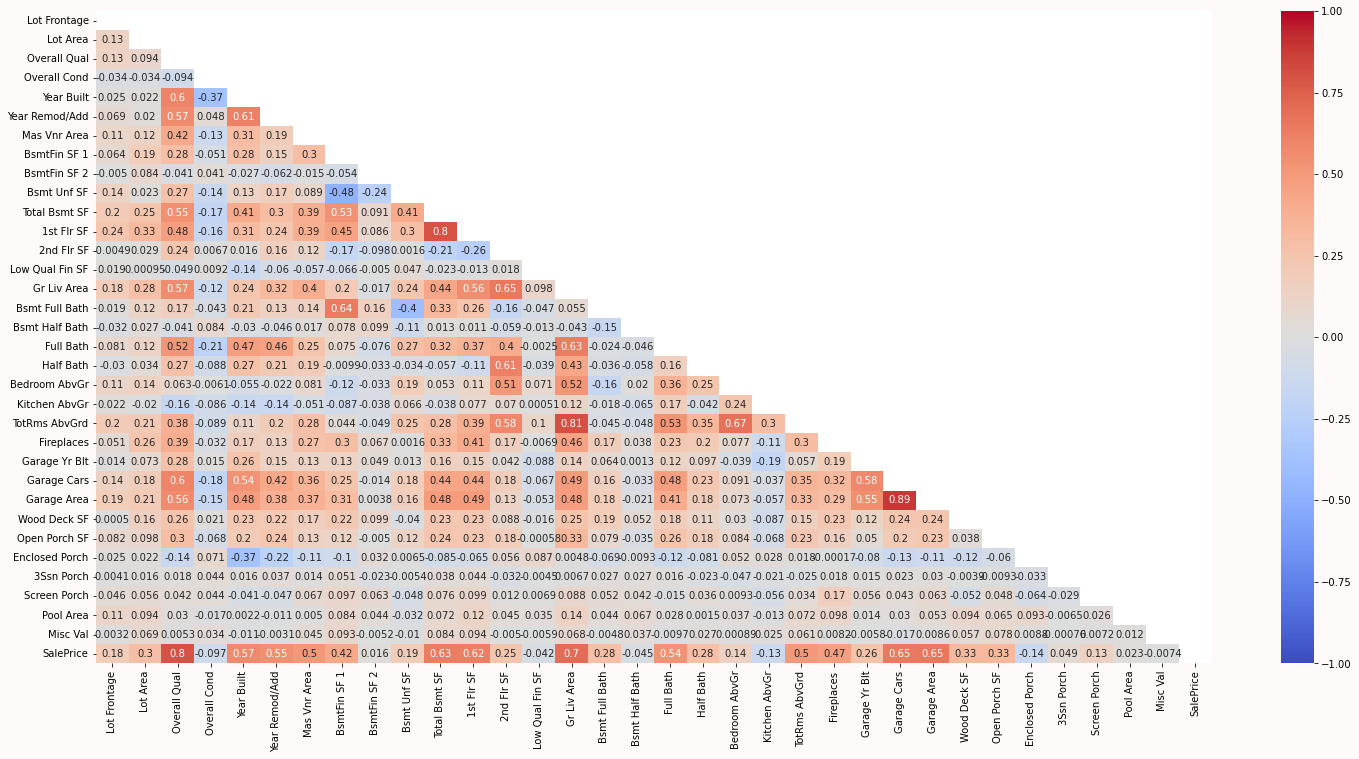

In [67]:
plt.figure(figsize=(25,12), facecolor='snow');

sns.heatmap(corr_matrix, 
             cmap='coolwarm',
             mask = mask,
             annot=True,
             vmin=-1,
             vmax=1);

plt.savefig('../images/heatmap.png')

There's quite a lot of information here being displayed at once. That being said, the key things to watch out for are the "hot" colors which are orange-to-red. We point out some moderate-to-strong relationships here:
- ```Overall Qual``` and ```Year Built```.
- ```BsmtFin SF 1``` and ```Bsmt Full Bath```.
- ```Total Bsmt SF``` and ```1st Flr SF```.
- ```2nd Flr SF``` and ```Half Bath``` as well as ```Full Bath```.
- ```Full Bath``` and ```TotRms AbvGrd```.
- ```Garage Yr Blt``` and ```Garage Area``` as well as ```Garage Cars```.

Most of these relationships make sense, e.g. newer houses probably have higher quality, larger basements have more basement bathrooms, basement size is limited by the 1st floor size.
- One very interesting observation though is that ```Garage Yr Blt``` correlates positively with the size of the garage: newer garages tend to be bigger and fit more cars.
- One possible explanation: cars may have gotten bigger over time, more people drive hence more cars in the household, etc. 
    - Of course, any rigorous justification of such claims would require looking at automotive data and would take us too far afield.
    - Still, it's very interesting that we are able to detect such patterns in our data. This may prove to be a good future project.
    
<br> 

Since our main interest is in ```SalePrice```, let us focus on this variable now.

In [68]:
# set up the correlation table with just SalePrice
saleprice_corr = corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False).iloc[1:].T

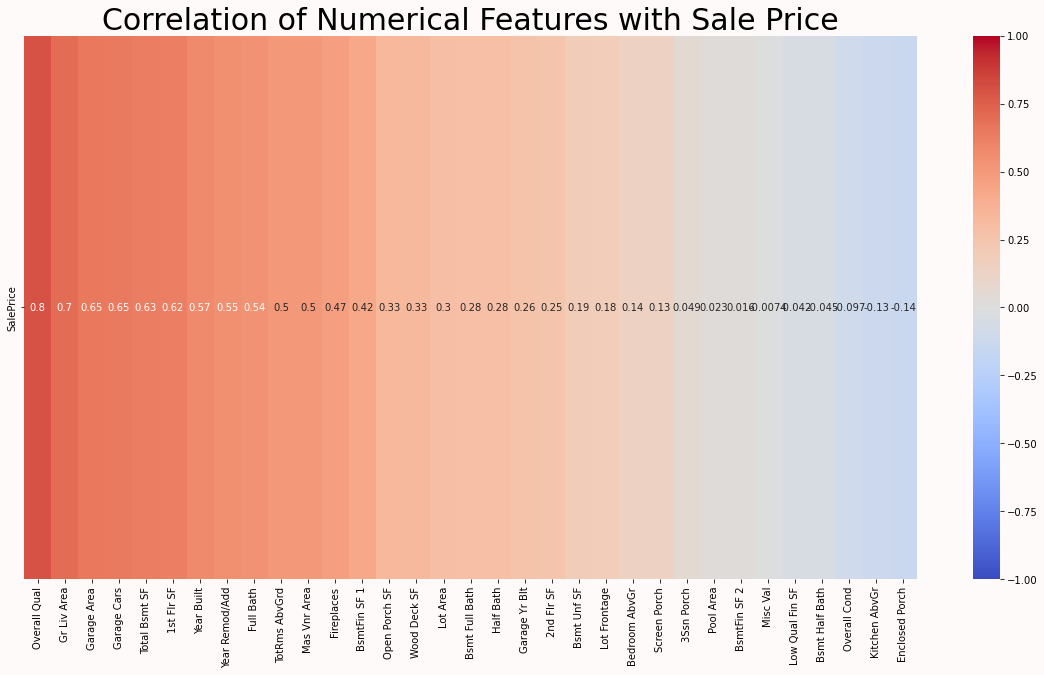

In [69]:
plt.figure(figsize=(20,10), facecolor='snow')
sns.heatmap(saleprice_corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True);
plt.title('Correlation of Numerical Features with Sale Price', fontsize=30);


plt.savefig('../images/saleprice-heatmap.png')

- Amongst the numerical variables, we see a pretty strong list of features that demonstrate high positive correlation with ```SalePrice``` . 
- Perhaps a bit *more* interesting are the variables that do not seem to have a high positive correlation with ```SalePrice```.
    - ```Pool Area``` has almost 0 correlation with ```SalePrice```, which seems counterintuitive since pools are considered by many people to be a luxury item.
    - ```Misc Val``` also has 0 correlation with ```SalePrice```, which is interesting sinse ```Misc Val``` directly tracks the value of miscellenous features, e.g. elevators.
    - ```Kitchen AbvGrd``` has slightly negative correlation with ```SalePrice```, which is also interesting. One would expect that extra kitchens would increase the price.
    
These 3 variables ```Pool Area```, ```Misc Val```, and ```Kitchen AbvGrd``` deserve to be investigated a bit further, since what we are seeing in the data does not match with what we expect to happen, so either we find a problem with the data or we update our own understanding of housing prices (win-win situation either way!).

## 3.2 Low Correlation Variables

### Pools

In [70]:
# distribution of Pool Area
ames.training[['Pool Area']].value_counts()

Pool Area
0            2042
228             1
368             1
480             1
519             1
561             1
576             1
648             1
738             1
800             1
dtype: int64

In [71]:
2042/len(ames.training.index)

0.9956118966357874

- Right away we see an issue: 99.6% of the houses have no pools.
- This makes it incredibly hard to make any predictions about houses with pools, since we just don't have enough of them to analyze properly.
- We suspect that this feature is thus not very useful for predicting ```SalePrice``` *in this specific data set*.
    - As a future research problem: find and train on a new data set of houses with a good number of pools.

Text(0.5, 1.0, 'Sale Price of Houses with No Pool')

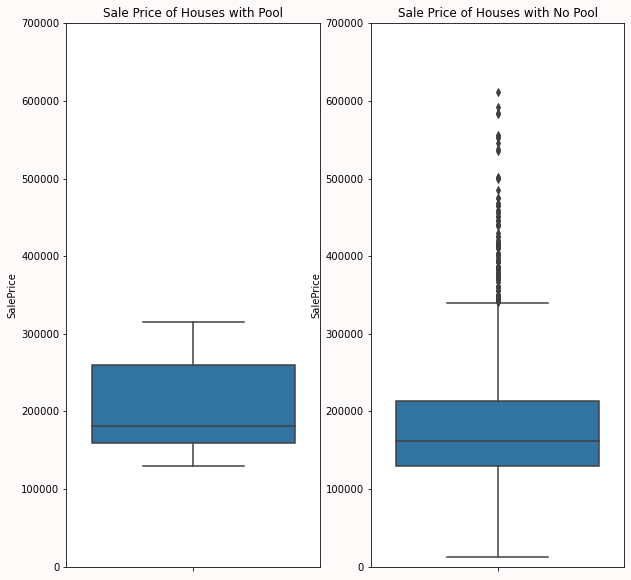

In [72]:
pool = ames.training[ ames.training['Pool Area'] > 0 ]
no_pool = ames.training[ ames.training['Pool Area'] == 0 ]


fig, ax = plt.subplots(1,2,figsize=(10,10), facecolor = 'snow');
sns.boxplot(y='SalePrice', data=pool, ax=ax[0]);
ax[0].set_ylim((0, 700_000));
ax[0].set_title('Sale Price of Houses with Pool');

sns.boxplot(y='SalePrice', data=no_pool, ax=ax[1]);
ax[1].set_ylim((0, 700_000));
ax[1].set_title('Sale Price of Houses with No Pool')

*Boxplot of Sale Price for homes with pools and no pools. The distributions are not significantly different enough to meaningfully deduce the effect of having a pool on Sale Price.*

### Misc Value

In [73]:
# distribution of Misc Value
ames.training['Misc Val'].value_counts()

0        1986
400        12
500         8
600         6
450         5
2000        5
700         4
1200        2
3000        2
2500        2
4500        2
17000       1
1300        1
900         1
1500        1
800         1
6500        1
54          1
3500        1
1150        1
300         1
455         1
8300        1
460         1
12500       1
480         1
650         1
80          1
Name: Misc Val, dtype: int64

In [74]:
1986/len(ames.training.index)

0.9683081423695759

- Just like with pools, almost all houses have a ```Misc Val``` of 0, which again makes it hard to deduce any meaningful relationship between ```Misc Val``` and ```SalePrice```. 

### Kitchens

In [75]:
# distribution of Kitchens
ames.training['Kitchen AbvGr'].value_counts()

1    1960
2      88
0       2
3       1
Name: Kitchen AbvGr, dtype: int64

In [76]:
1960/len(ames.training.index), 88/len(ames.training.index)

(0.9556313993174061, 0.04290589956118966)

- Over 95% of houses have exactly 1 kitchen. About 4% of houses have 2 kitchens.


In all 3 variables, we see that disproportionately large amount of houses are concentrated at a single value of those variables.
- This makes it impossible to properly observe effects between these variables and ```SalePrice```: there just aren't enough houses with pools, miscellenous features, and multiple kitchens to compare against.
- More formally, these variables could have a legitimate effect on Sale Price, but the sample sizes are so small for these variables that the effect is being drowned out by the random noise in the data.


## 3.3 Categorical Variables

Let's begin by taking a look at the bargraphs and boxplots of the categorical variables. Of course, with so many features to consider, its near impossible to find all the details on a first pass. Nonetheless we shall try to scan for extreme phenomena first as these are most noticeable.

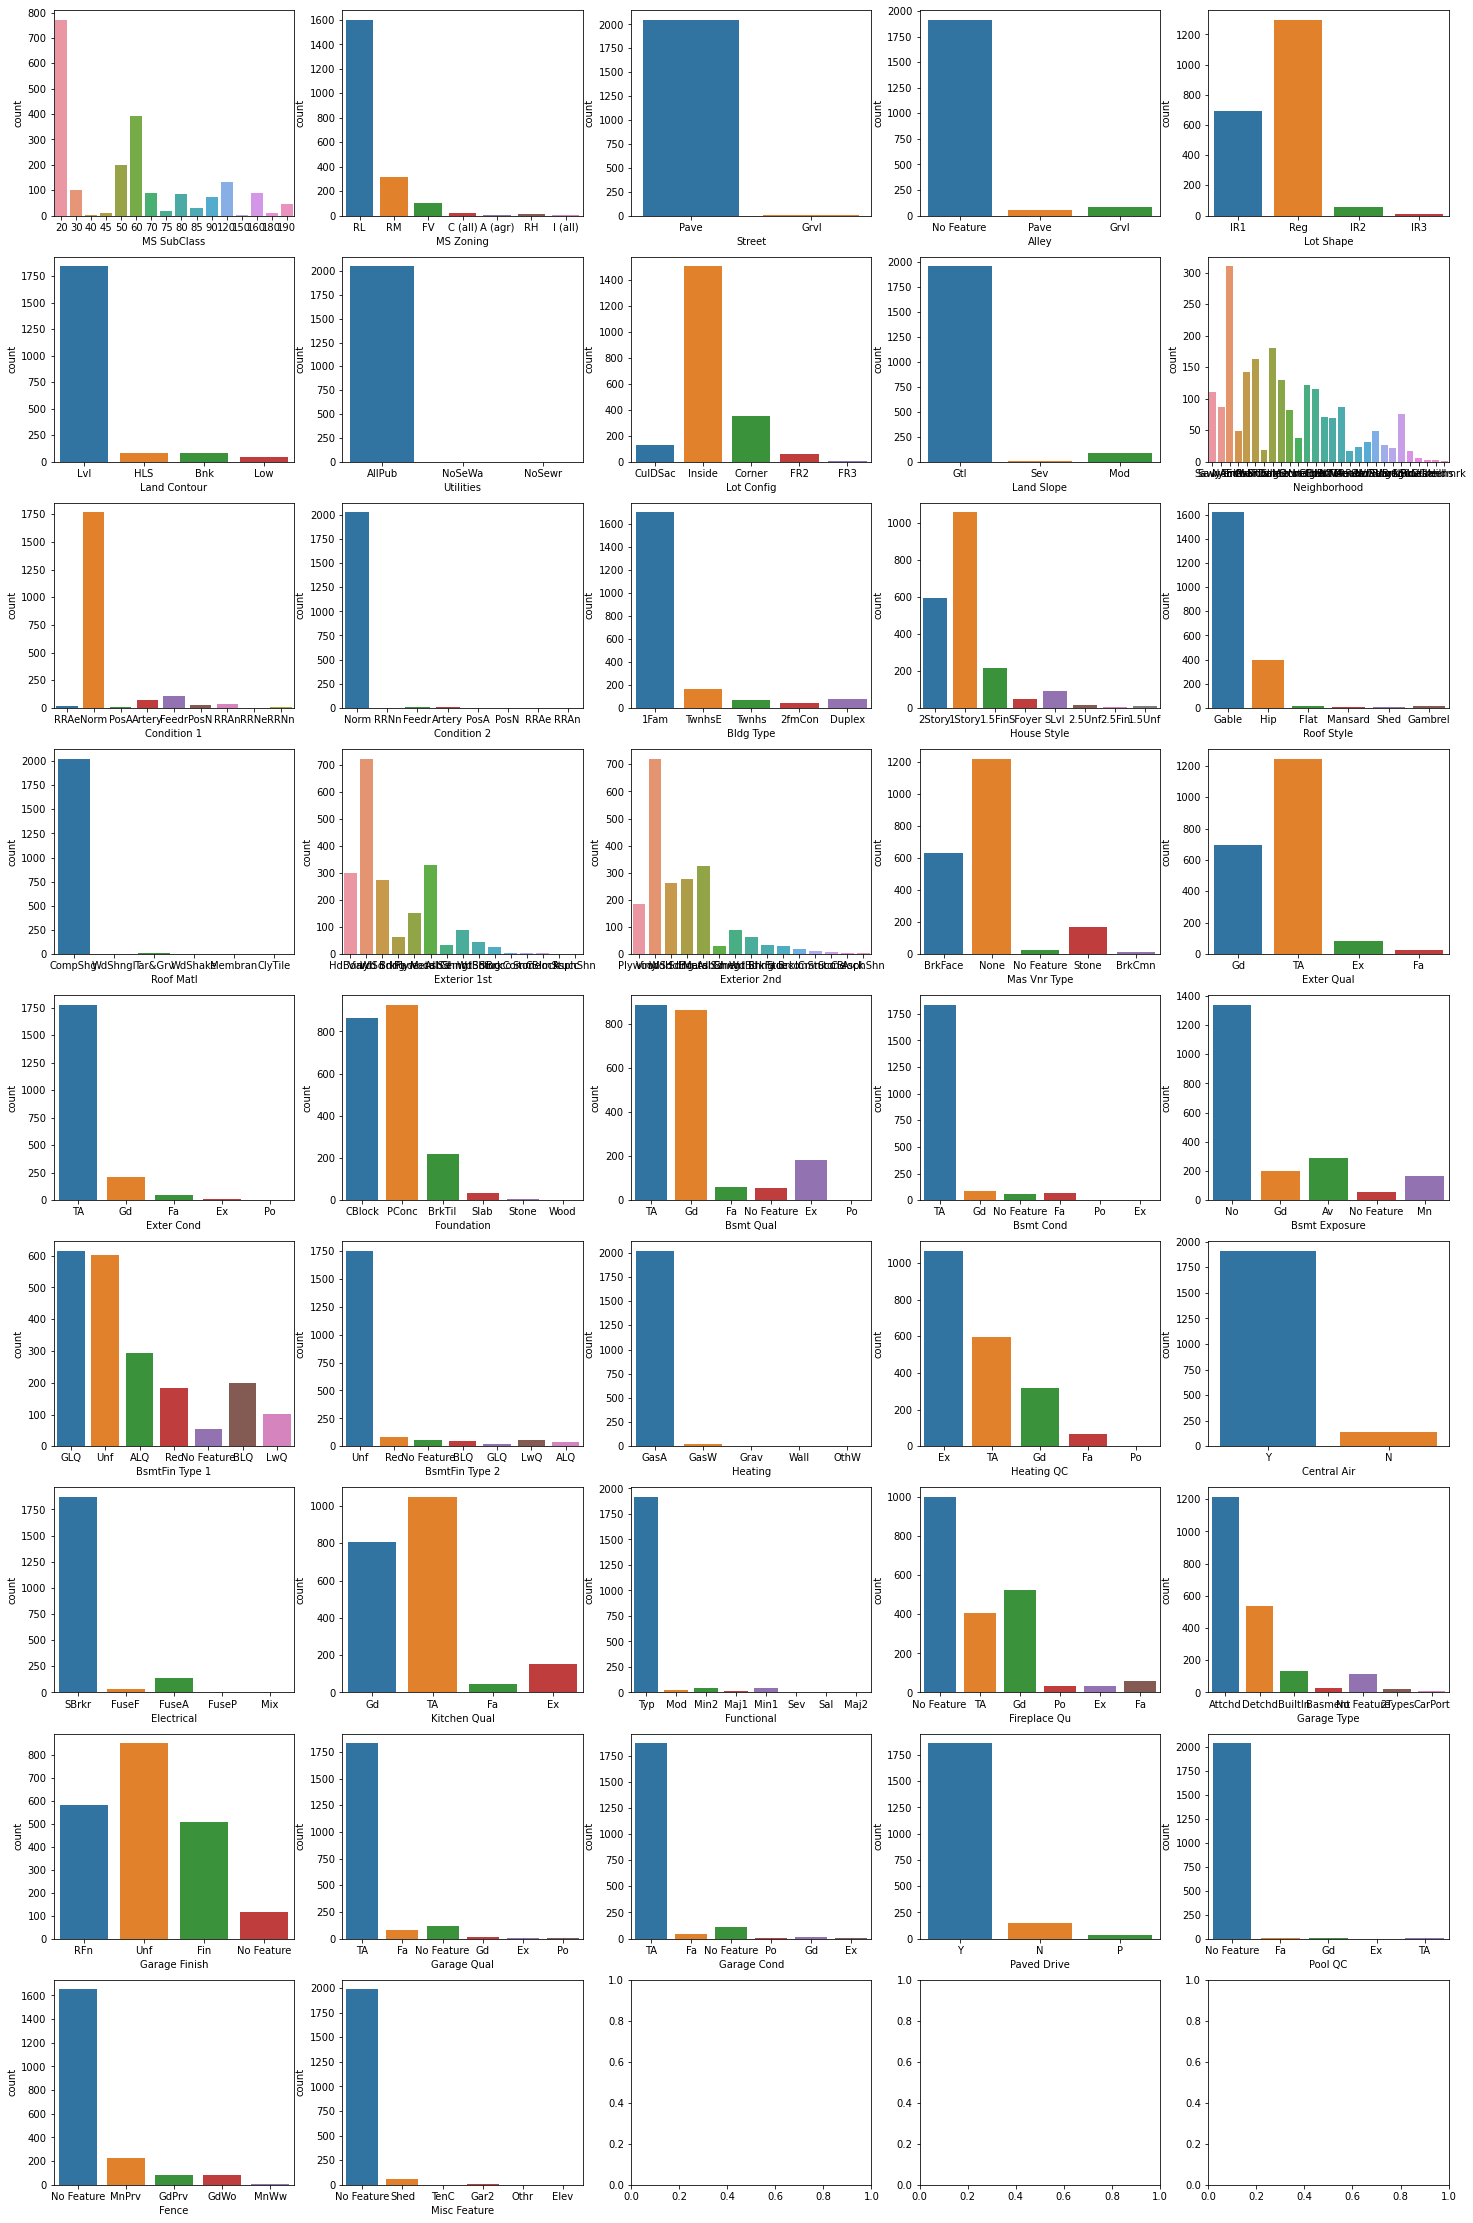

In [77]:
jarvis.bargraphs(ames.training, columns = ames.categoricals, figsize=(25,40))

- We see quite a few features have disproportionate categorical allotments: ```Street```, ```Utilities```, ```Condition 2```, ```Roof Mtl```, ```Heating```, ```Pool QC```,  and ```Misc Feature```. 


This makes it very hard to use these features to deduce any pattern because the variation in the categories are just too small. (It's hard to say if ```Roof Mtl``` affects housing price when there are only a few houses with different materials).

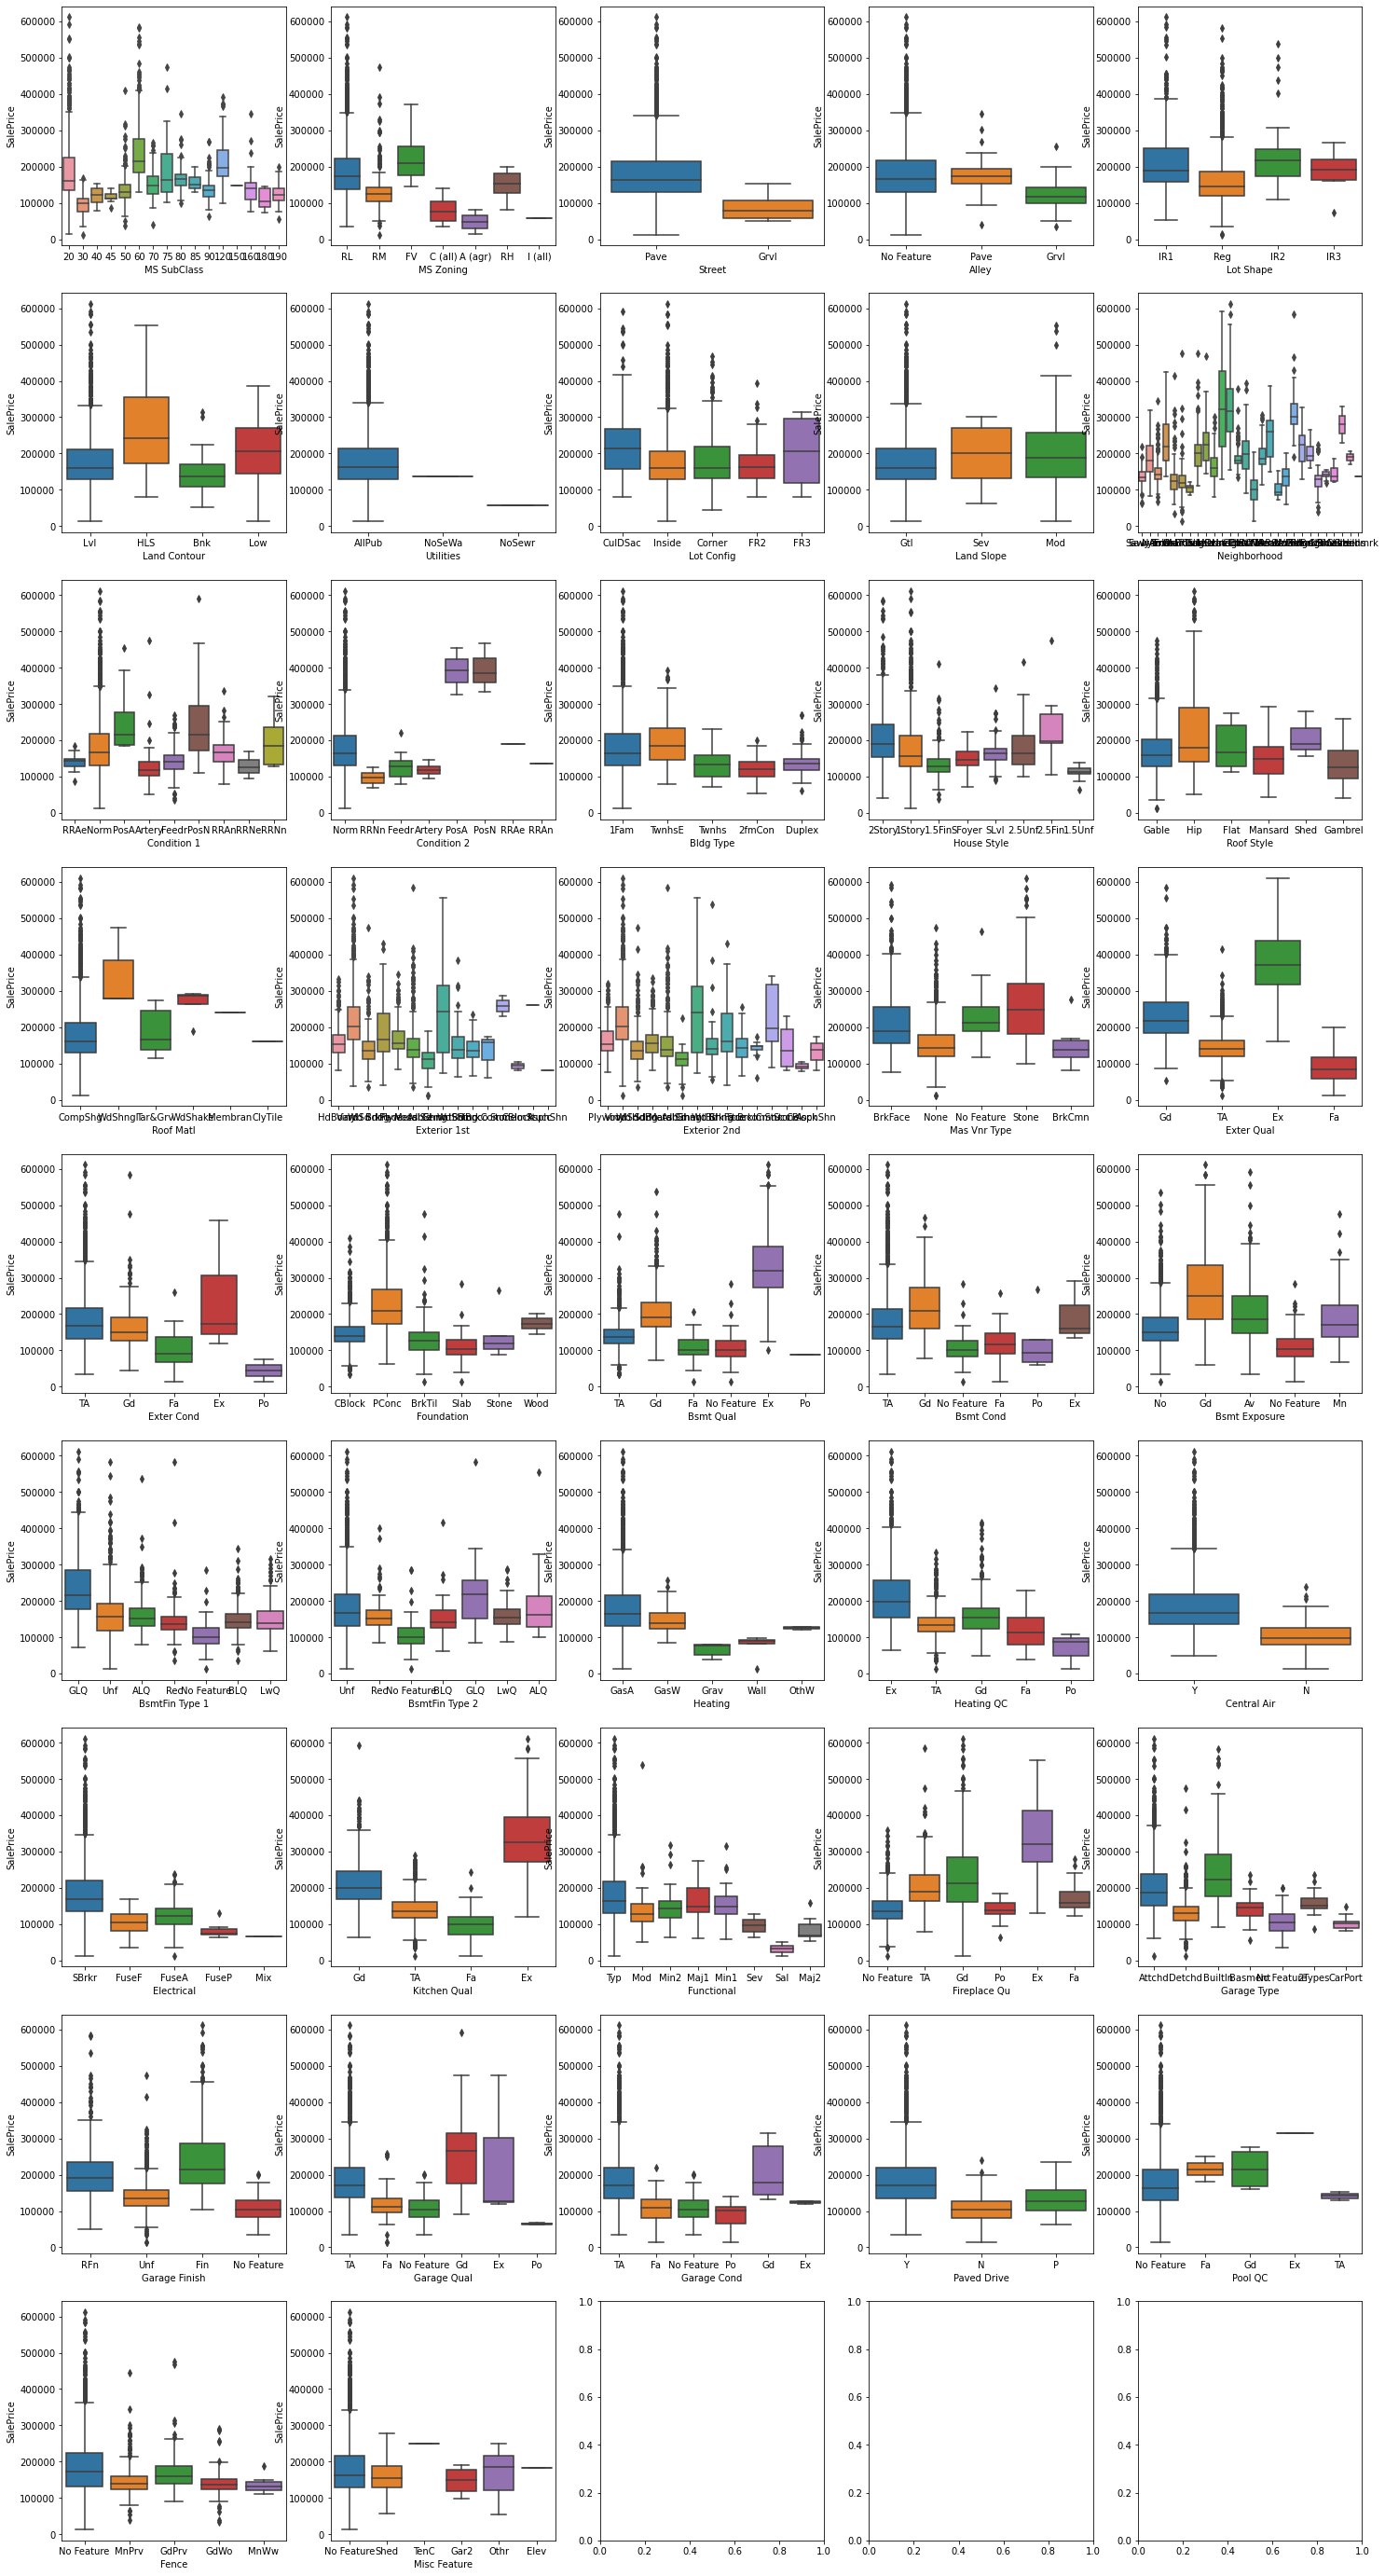

In [78]:
# draw boxplots of ALL categorical variables (you have been warned!)
jarvis.boxplots(ames.training, columns = ames.categoricals, y='SalePrice', figsize=(25, 50))

- Almost every category of each variable has a right-skewed distribution for ```SalePrice```. Thus there seems to a subset of homes which are of significantly higher value than all the other homes, even when holding categories constant. 
- One possible explanation: house prices are determined by combinations of categorical features, which isn't reflected by these individual boxplots.